<a href="https://colab.research.google.com/github/Annrrt/Diplomado-Modulo6/blob/main/Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar los datos de entrenamiento
train_data = pd.read_csv('/content/Walmart_Store_sales.csv', parse_dates=True)
train_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
#Buscar datos NaN
train_data[train_data.isnull().any(axis=1)]


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


In [4]:
#Eliminar filas con NaN
train_data.dropna(inplace=True)

In [5]:
train_data['Date'] = pd.to_datetime(train_data['Date'], dayfirst=True)

train_data['Month'] = train_data['Date'].dt.month

train_data.drop(columns=['Date'], inplace=True)

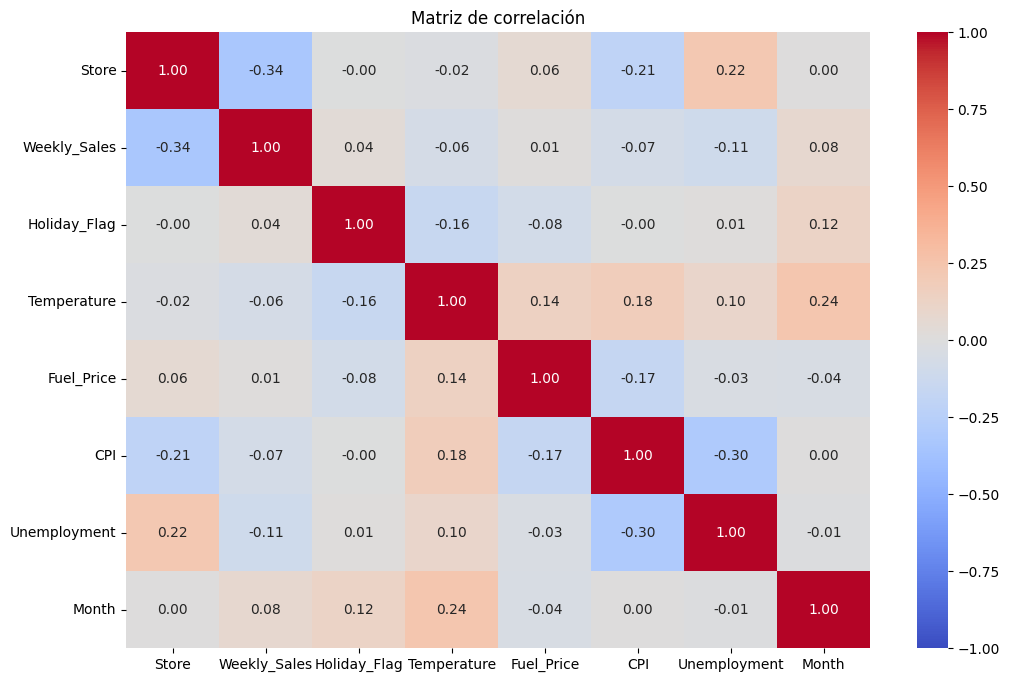

In [6]:
#Matriz de correlacion
corr = train_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación")
plt.show()

In [7]:
columns = ['Weekly_Sales','Fuel_Price','CPI','Unemployment']
train_data_df = pd.DataFrame(train_data, columns=columns)
train_data_or = train_data_df[['Weekly_Sales','Fuel_Price','CPI','Unemployment']]

In [8]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data_or)


In [9]:
# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



In [10]:
train_size = int(len(train_scaled) * 0.8)
train_data = train_scaled[:train_size]
test_data = train_scaled[train_size - 12:]

In [11]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [24]:
# Modelo LSTM
model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 256)        │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,833 (1.35 MB)

 Trainable params: 352,193 (1.34 MB)

 Non-trainable params: 640 (2.50 KB)

In [26]:
# Entrenar el modelo

model.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True),
    ],
    verbose=1)


Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.7101 - val_loss: 0.4540
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.5525 - val_loss: 0.4320
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.4968 - val_loss: 0.3910
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.4496 - val_loss: 0.3686
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.4138 - val_loss: 0.3462
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.3839 - val_loss: 0.3251
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.3603 - val_loss: 0.3079
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.3362 - val_loss: 0.2930
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 0.3143 - val_loss: 0.2723
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.2957 - val_loss: 0.2567
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.2762 - val_loss: 0.2399
Epoch 12/100
161/16

In [27]:
loss = model.evaluate(X_train, y_train)
print("Pérdida en test:", loss)

161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0027
Pérdida en test: 0.0023532670456916094


In [28]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(train_scaled[-12:], 12)

In [29]:
predictions_scaled = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [30]:
print(predictions_scaled.shape)

(1287, 1)


In [31]:
y_pred = model.predict(X_train)

161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [32]:
# Predicciones

predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(
    np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 3))], axis=1)
)[:, 0]

real = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), 3))], axis=1)
)[:, 0]
y_pred = y_pred[:len(y_test)]

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


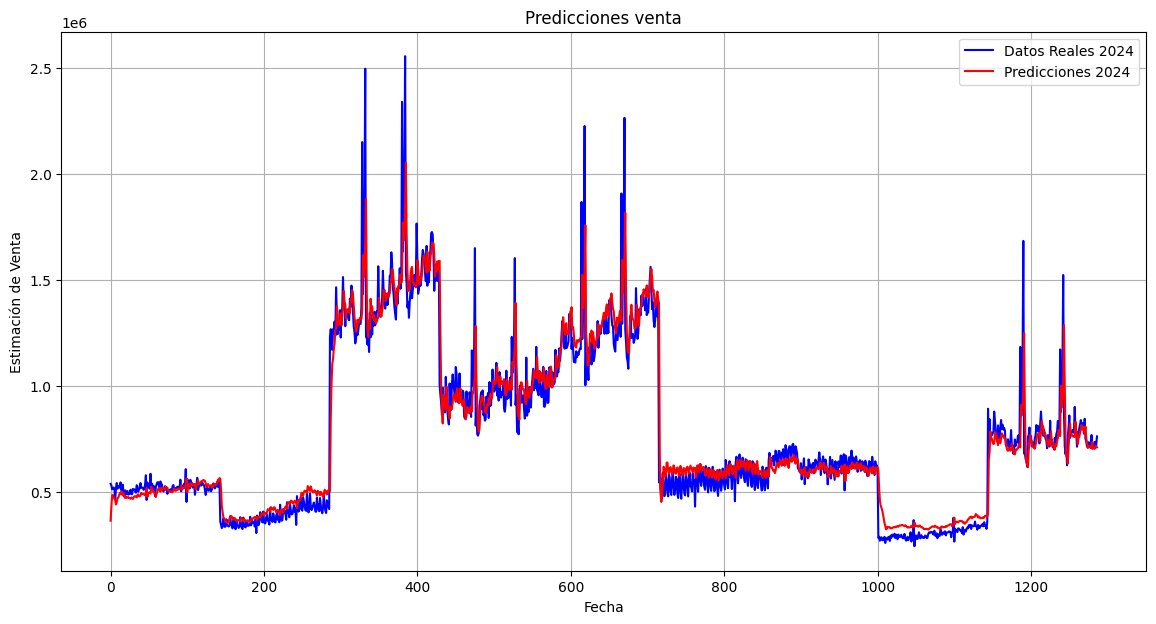

In [33]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real, label='Datos Reales 2024', color='blue')
plt.plot(predictions, label='Predicciones 2024', color='red')
plt.title('Predicciones venta')
plt.xlabel('Fecha')
plt.ylabel('Estimación de Venta')
plt.legend()
plt.grid(True)
plt.show()
